In [156]:
#
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook


#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random
import geopy
#
#colors_ =  mpl.rcParams['axes.color_cycle']
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']		# make sure these are correct...
tzutc = pytz.timezone('UTC')
#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


data handle fetched...
 no file.
cat_len:  101
len new catalog:  101
begin globalETAS.__init()__
ETAS over etas_cat_range/xyz_range:  ([0, 101], None)
make_etas():
begin make_etas_rtree()
len(local_lattice_dict):  400
Indices initiated. begin ETAS ::  [0, 101]
finished calculateing ETAS (rtree). wrap up in recarray and return.
ETAS complete.
evecs:  [  8.09566453e-01   5.55111512e-17] [[ 0.86536104  0.50114896]
 [-0.50114896  0.86536104]]
xprime:  [ 0.86536104  0.50114896] [-0.50114896  0.86536104]
x_prime dot y_prime:  0.0 0.0 [ 0.43268052  0.25057448] [-0.40571338  0.70056726] 0.0
evecs:  [[ 0.86536104  0.50114896]
 [-0.50114896  0.86536104]]


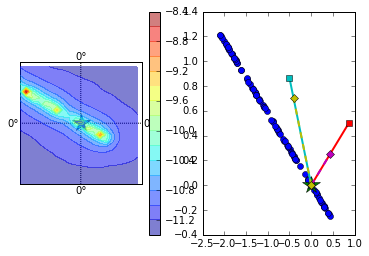

In [157]:
theta = (5./6.)*3.14
#
#ut = globalETAS.elliptical_transform_test(theta = 3.15/4., x0=0., y0=0., n_quakes=100, m=6.0, max_ratio=2.0, fignum=0)
aa=globalETAS.elliptical_transform_test(theta=theta, m=7., dm=3.)
print('evecs: ', aa['catalog'][-1]['e_vecs'])

In [158]:
# TODO: wtf? check out:
#> globalETAS.elliptical_transform_test(theta = 0., x0=0., y0=0., n_quakes=100, m=6.0, max_ratio=2.0, fignum=0):
# this seems to work really well. it should be pretty much exactly the test we're writing here.

class orientation_test(object):
    
    def __init__(self, N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., dt=2.,
                     t0=dtm.datetime(2016,1,1, tzinfo=tzutc)):
        #
        # TODO:
        # something odd going on so that the transformation is not fitting correctly, but we don't see this
        # in the globalETAS.py unit test, and i don't think we see it in actualy ETAS instances... but
        # we should sort it out.
        # the globalETAS script seems to get the right pca transform; let's figure out what we're doing wrong
        # and confirm that it's not happing in real life.
        #
        L_r = 10.**(.5*m0 - 1.76)
        L = 3.5*L_r
        #print('**L,L_r = ', L, L_r)
        d_LL = L/111.1
        y_scatter = 0.
        #
        R = random.Random()
        r_factor=.2
        km2_ll = 1./111.
        m = m0-dm
        m_ms = m0
        #
        #d_lat = km2_ll*L*math.sin(theta)/N_ev
        #d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
        dt = dtm.timedelta(days=dt)
        dy0=0.
        #dy0=.5*L
        LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
        LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
        #
        print('LLs: ', LLs[0:5])
        #print('theta: ', theta)
        M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
        #print('M_r: ', M_r)
        LLs = numpy.dot(LLs, M_r)
        #
        cat = []
        #for j in range(N_ev):
        #    cat += [[t0+dt*j, lon0+j*d_lon*(1.0+R.random()*r_factor), lat0+j*d_lat*(1.0+R.random()*r_factor), m-3., mpd.date2num(t0+dt*j) ]]
        for j, (lon,lat) in enumerate(LLs):
            cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
        #
        tms = cat[int(.5*len(cat))][0]
        #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
        #        mpd.date2num(cat[-1][0]+dt) ]]
        cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
                mpd.date2num(tms+.5*dt) ]]
        #
        cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])
        cat_original = cat.copy()
        #cat = gep.make_ETAS_catalog_mpp(cat)
        cat = gep.make_ETAS_catalog(cat, fit_factor=2.0)
        #
        # get the pca transform (for debugging):
        xy = [cat['lon'], cat['lat']]
        cov = numpy.cov(xy)
        print('evals/vecs: ', numpy.linalg.eig(cov))
        #
        # get default lat/lon ranges:
        delta_lats = max(cat['lat']-min(cat['lat']))
        delta_lons = max(cat['lon']-min(cat['lon']))
        delta_lls = max(delta_lats, delta_lons)*.5
        lat_0 = numpy.mean(cat['lat'])
        lon_0 = numpy.mean(cat['lon'])
        my_lats = [lat_0-delta_lls, lat_0+delta_lls]
        my_lons = [lon_0-delta_lls, lon_0+delta_lls]
        #etas = gep.ETAS_mpp(catalog=cat, lons=sorted(cat['lon'])[0::len(cat)-1],  lats=sorted(cat['lat'])[0::len(cat)-1]),
        etas = gep.ETAS_mpp(catalog=cat, lats=my_lats, lons=my_lons )
        #
        plt.figure(figsize=(8,6))
        plt.clf()
        plt.plot(cat['lon'], cat['lat'], marker='o', ls='')
        plt.plot(cat['lon'][-1], cat['lat'][-1], marker='*', color='r', ls='', ms=16)
        #plt.plot(cat2['lon'], cat2['lat']+.25, marker='o', ls='', color='r')'
        for x,y in itertools.product(sorted(cat['lon'])[0::len(cat)-1], sorted(cat['lat'])[0::len(cat)-1]):
            plt.plot([x],[y], '.')
        #
        #return etas
        self.__dict__.update(locals())

   

LLs:  [[-0.86561344  0.        ]
 [ 0.86561344  0.        ]
 [-0.24525191  0.        ]
 [-0.05466076  0.        ]
 [-0.14395064  0.        ]]
evals/vecs:  (array([  3.97818580e-02,  -1.73472348e-18]), array([[ 0.86536104,  0.50114896],
       [-0.50114896,  0.86536104]]))
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], None)
make_etas():
etas_mpp worker xyz_range:  [0, 225]
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 103], [0, 225])
begin make_etas_rtree()
len(local_lattice_dict):  225
Indices initiated. begin ETAS ::  [0, 103]
now gather sub-arrays...
finished calculateing ETAS (rtree). wrap up in recarray and return.
eta

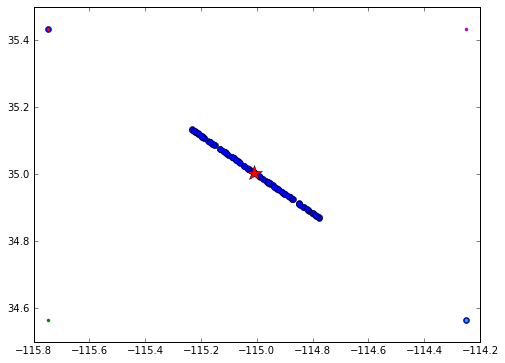

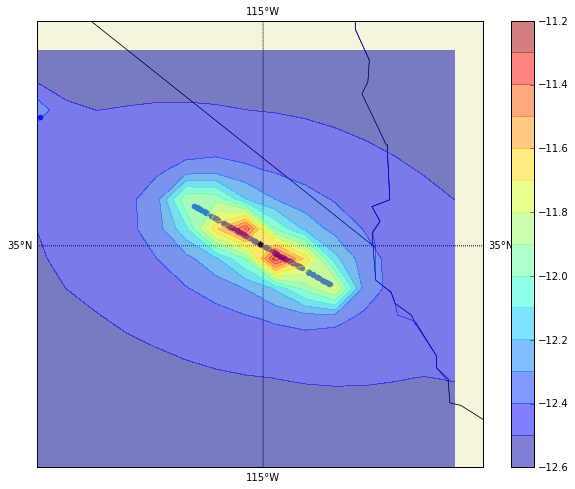

In [159]:
#etas = orientation_test(N_ev=50, theta=0.*3.14/4.)
#for theta in [3.14/6, 3.14/4., 3.14/2., .75*3.14]:
for theta in [theta]:
    etas = None
    etas = orientation_test(N_ev=100, theta=theta, m0=7., dm=4.)
    #
    plt.figure(figsize=(10,8))
    plt.clf()
    ax=plt.gca()
    etas.etas.make_etas_contour_map(ax=ax)
    ms=etas.etas.catalog[0]
    for ev in etas.etas.catalog:
        #
        if ev['mag']>ms['mag']: ms=ev
        x,y = ev['lon'], ev['lat']
        etas.etas.cm.scatter(x,y, marker='o', edgecolors='b')
    print(etas.etas.catalog[-1])
    etas.etas.cm.scatter(ms['lon'], ms['lat'], marker='*', s=28, c='m', zorder=11)
print('finished...')

max_mag = max(etas.etas.catalog['mag'])


### Elliptical transform test:
 Are we doingthe elliptical transform correctly? This is actually very difficut to know for sure when we have other earthquakes in the sequence, so just grab one; make a catalog, make an ETAS, and force its rotation. If the transforms for the real(ish) map are wrong, but this works properly, the problem is with the orientation fitting.

In [160]:
max_mag=etas.etas.catalog['mag'][0]
rw = etas.etas.catalog[0]
for rw in etas.etas.catalog:
    if rw['mag']>=max_mag:
        new_cat = numpy.array([rw], dtype=etas.etas.catalog.dtype)
        break

print('new_cat: ', new_cat)
#
for rw in new_cat: print('rw: ', rw)
print('mag: ', new_cat['mag'])

n_events=150
#theta = -3.14/4.
#
# theta is from where? if we put a bunch of dots (earthquakes) in a line on the x axis, this
# corresponds to 0 degrees/radians.
# TODO: in later unit tests, make some events; plot them; get their PCA, then do the single event
# ETAS contours over the top... for now, we can say that the elliptical transform is working.
R=random.Random()
L = .01*3.0*10**(.5*rw['mag']-1.76)
L = 2.5
#
d_lat=2.5
d_lon=2.5

new_cat:  [ (datetime.datetime(2016, 1, 1, 0, 0), -114.25093185917547, 34.56619872766932, 3.0, 735964.0, 0.5495408738576245, 0.051682895650509875, 27.819964832922334, 0.16595869074375613, 0.0027285955130155206, 57.069764961619526, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 1.0)]
rw:  (datetime.datetime(2016, 1, 1, 0, 0), -114.25093185917547, 34.56619872766932, 3.0, 735964.0, 0.5495408738576245, 0.051682895650509875, 27.819964832922334, 0.16595869074375613, 0.0027285955130155206, 57.069764961619526, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 1.0)
mag:  [ 3.]


calcing etas on new_cat (1)
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 2500]
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 2500])
begin make_etas_rtree()
now gather sub-arrays...
len(local_lattice_dict):  2500
Indices initiated. begin ETAS ::  [0, 1]
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 1])
ETAS complete.


/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:323: RuntimeWarning: divide by zero encountered in log10
  Z = numpy.log10(self.lattice_sites)


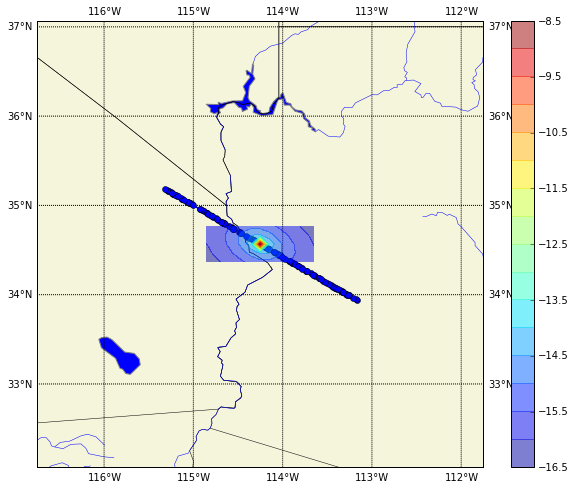

In [161]:
# make an earthquake; force it's orientation (eigenvalues) along a strike(ish) of theta. to ETAS contours
# around that event, then plot a bunch of dots (pseudo events) along that vector.
# TODO: make this better. make a catalog of all these events; fetch the eigenvectors from the large event (from fitting
# the small events).
#new_cat['mag']=6.
new_cat['e_vals'] = numpy.array([2.0, 1.0])
new_cat['e_vecs'] = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
print('calcing etas on new_cat ({})'.format(len(new_cat)))
new_etas = gep.ETAS_mpp(catalog=new_cat, lats=[rw['lat']-d_lat, rw['lat']+d_lat], lons=[rw['lon']-d_lon, rw['lon']+d_lon] )

xy = numpy.array([[L*(R.random()-.5), 0.] for j in range(n_events)])
xy_prime = numpy.dot(xy, new_cat[0].e_vecs.T)
xy_prime += numpy.array([new_cat[0]['lon'], new_cat[0]['lat']])
pca = gep.get_pca(xy_prime)
#
plt.figure(figsize=(10,8))
plt.clf()
ax=plt.gca()
new_etas.make_etas_contour_map(ax=ax)
#new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
new_etas.cm.plot(*zip(*xy_prime), marker='o', color='b', zorder=7)


# now, let's make a bogus catalog from xy_prime and see if we can't get the catalog maker to properly fit it.
#
t0 = dtm.datetime(2016,1,1, tzinfo=pytz.utc)
dt=dtm.timedelta(hours=1.)
m0 = 3.0
dm = 3.0
#
new_cat = [[t0+j*dt, y, x, m0, mpd.date2num(t0+j*dt)] for j, (x,y) in enumerate(xy_prime)]
#
tf_ms = numpy.mean([rw[-1] for rw in new_cat])
x_ms = numpy.mean([rw[2] for rw in new_cat])
y_ms = numpy.mean([rw[1] for rw in new_cat])

new_cat += [[mpd.num2date(tf_ms), y_ms, x_ms, m0+dm, tf_ms]]

new_cat = numpy.core.records.fromarrays(zip(*new_cat), dtype = [('event_date', 'datetime64[us]'),
                                                                ('lat', '>f8'), ('lon', '>f8'), ('mag', '>f8'),
                                                               ('event_date_float', '>f8')])

In [162]:
etas_cat_test = gep.make_ETAS_catalog(new_cat, fit_factor=2.)

#print(etas_cat_test)
#plt.figure()
#plt.clf()
#plt.plot(*zip(*xy_prime), 'o')

In [163]:
print(len(new_cat[0]), len(new_cat.dtype))

j_max, rw_max = 0,etas_cat_test[0]
for j,rw in enumerate(etas_cat_test):
    if rw['mag']>rw_max['mag']:
        j_max=j
        rw_max=rw
#
print('dtypes: ', etas_cat_test.dtype)
rw_max['e_vecs']

5 5
dtypes:  (numpy.record, [('event_date', '<M8[us]'), ('lat', '>f8'), ('lon', '>f8'), ('mag', '>f8'), ('event_date_float', '>f8'), ('L_r', '<f8'), ('r_0', '<f8'), ('chi', '<f8'), ('dt_r', '<f8'), ('t_0', '<f8'), ('tau', '<f8'), ('dmstar', '<f8'), ('p', '<f8'), ('q', '<f8'), ('e_vals', '>f8', (2,)), ('e_vecs', '>f8', (2, 2)), ('N_eig_cat', '>f8')])


array([[ 0.86536104,  0.50114896],
       [-0.50114896,  0.86536104]])

In [164]:
for rw in etas_cat_test:
    if rw['mag']>3.0: print(rw)

(datetime.datetime(2016, 1, 4, 2, 30), 34.55049777683279, -114.22382017739292, 6.0, 735967.1041666666, 17.378008287493753, 84.65108954313368, 0.0006874066346783245, 5.248074602497728, 8.62857663444466, 0.02549212761626736, 1.0, 1.1, 1.5, array([  5.35094989e-01,   5.55111512e-17]), array([[ 0.86536104,  0.50114896],
       [-0.50114896,  0.86536104]]), 56.0)


In [165]:
print('theta: ', theta, theta/3.141)

theta:  2.6166666666666667 0.8330680250451025


### more transform tests:
- use a toy catalog
- generate a globalETAS catalog; it should fit all events, namely the big one.
- now, grab just that event and do a single-event etas.
- compare to orientation of events.

In [166]:
print(etas.cat_original[0:3])
print(max(etas.cat_original['mag'])) 
#
gep_cat = etas.cat_original.copy()
# add a mainshock (assign a large magnidute to the middle event):
gep_cat[int(len(gep_cat)/2)]['mag'] +=3.
gep_cat = gep.make_ETAS_catalog_mpp(incat=etas.cat_original, fit_factor=2.5)

print('\nmainshock: {}\n'.format([rw for rw in gep_cat if rw['mag']==max(gep_cat['mag'])]))

[ (datetime.datetime(2016, 1, 1, 0, 0), -114.25093185917547, 34.56619872766932, 3.0, 735964.0)
 (datetime.datetime(2016, 1, 3, 0, 0), -115.74906814082453, 35.43380127233068, 3.0, 735966.0)
 (datetime.datetime(2016, 1, 5, 0, 0), -114.78776855626006, 34.87709226263232, 3.0, 735968.0)]
7.0
etas_prams:  {'do_recarray': False, 'mc': 2.5, 'p': 1.1, 'incat': None, 'b2': 1.5, 'D_fract': 1.5, 'd_tau': 2.28, 'fit_factor': 2.5, 'dmstar': 1.0, 'b1': 1.0, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f860b261978>), datetime.datetime(2016, 12, 11, 6, 32, 4, 845698, tzinfo=<UTC>)], 'd_lambda': 1.76, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'q': 1.5}
results fetched.

mainshock: [(datetime.datetime(2016, 4, 13, 0, 0), -115.00961835730565, 35.00557019503236, 7.0, 736067.0, 54.954087385762456, 997.8404925454946, 2.0021630113650087e-05, 16.595869074375614, 126.65018464658773, 0.0019486750167964611, 1.0, 1.1, 1.5, array([  3.97818580e-02,  -1.73472348

begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 900]
begin globalETAS.__init()__
Overriding t0 (etas catalog start date/time) for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2011-12-13 06:31:45.071295+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 900])
begin make_etas_rtree()
now gather sub-arrays...
len(local_lattice_dict):  900
Indices initiated. begin ETAS ::  [0, 1]
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 1])
ETAS complete.


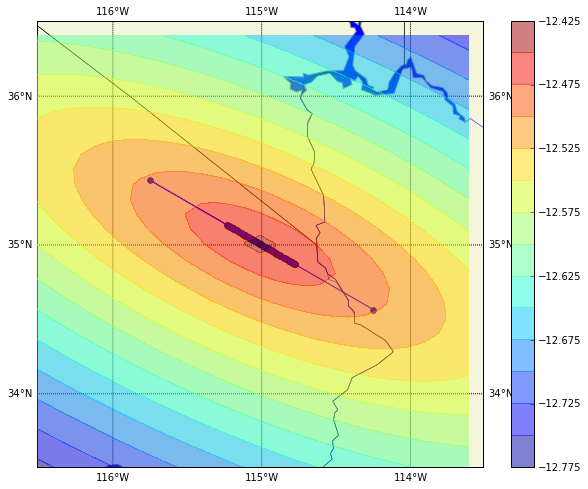

In [167]:
#
# get just the mainshock:
max_mag = max(gep_cat['mag'])
rw = gep_cat[0]
for rw in gep_cat:
    if rw['mag']>=max_mag:
        ms_cat = numpy.array([rw], dtype=etas.etas.catalog.dtype)
        mainshock = rw
        break
        

d_lat=1.5
d_lon=1.5
mylats = [rw['lat']-d_lat, rw['lat']+d_lat]
mylons = [rw['lon']-d_lon, rw['lon']+d_lon] 
ms_etas = gep.ETAS_mpp(catalog=ms_cat, lats=mylats, lons=mylons, ab_ratio_expon=0.)

#
plt.figure(figsize=(10,8))
plt.clf()
ax=plt.gca()
ms_etas.make_etas_contour_map(ax=ax, lats_map=mylats, lons_map=mylons)
#new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
#new_etas.cm.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7, latlon=True)

#plt.figure()
ax.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7)

In [168]:
print(ms_etas.ab_ratio_expon)

0.0


In [169]:
print(ms_etas.catalog)

[ (datetime.datetime(2016, 4, 13, 0, 0), -115.00961835730565, 35.00557019503236, 7.0, 736067.0, 54.954087385762456, 997.8404925454946, 2.0021630113650087e-05, 16.595869074375614, 126.65018464658773, 0.0019486750167964611, 1.0, 1.1, 1.5, array([  3.97818580e-02,  -1.73472348e-18]), array([[ 0.86536104,  0.50114896],
       [-0.50114896,  0.86536104]]), 103.0)]


In [170]:
print(ms_cat)

[ (datetime.datetime(2016, 4, 13, 0, 0), -115.00961835730565, 35.00557019503236, 7.0, 736067.0, 54.954087385762456, 997.8404925454946, 2.0021630113650087e-05, 16.595869074375614, 126.65018464658773, 0.0019486750167964611, 1.0, 1.1, 1.5, array([  3.97818580e-02,  -1.73472348e-18]), array([[ 0.86536104,  0.50114896],
       [-0.50114896,  0.86536104]]), 103.0)]
